## Accessing ASTER L1T data with the Planetary Computer STAC API

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to include your API key.

In [1]:
from pystac_client import Client
import planetary_computer as pc

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here
# pc.settings.set_subscription_key(<YOUR API Key>)

### Open and explore the ASTER collection

Using [pystac_client](https://github.com/stac-utils/pystac-client) we can fetch information about the [ASTER L1T](http://aka.ms/ai4edata-aster) collection:

In [2]:
catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
aster_l1t = catalog.get_child(id='aster-l1t')

Let's look at the temporal extent of the collection; the Planetary Computer ASTER L1T dataset contains images from 2000 to 2006:

In [3]:
aster_l1t.extent.temporal.to_dict()

{'interval': [['2000-03-04T12:00:00Z', '2006-12-31T12:00:00Z']]}

### Choose a region and time of interest

For this example we'll search 2002 imagery over an area in Japan:

In [4]:
time_of_interest = "2002-01-01/2002-12-31"

area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [138.4222412109375,34.90620544067929],
            [138.58428955078125,34.90620544067929],
            [138.58428955078125,35.07271701786369],
            [138.4222412109375,35.07271701786369],
            [138.4222412109375,34.90620544067929]
        ]
    ],
}

### Search the collection and explore the results

We'll use this criteria to perform a search against the STAC API:

In [5]:
search = catalog.search(
    collections=['aster-l1t'], 
    intersects=area_of_interest, 
    datetime=time_of_interest    
)
print(f"{search.matched()} Items found")

33 Items found


Each of those Item objects represents one ASTER scene.  Let's see what assets are available for each ASTER scene:

In [6]:
available_assets = list(aster_l1t.extra_fields['item_assets'].keys())
print(available_assets)

['TIR', 'xml', 'SWIR', 'VNIR', 'qa-txt', 'qa-browse', 'tir-browse', 'vnir-browse']


### Render a thumbnail image

ASTER data includes thumbnail images in the 'tir-browse' and 'vnir-browse' assets attached to each item.  Let's render one of those thumbnails.

Each Item has an `href` field containing a URL to the underlying image. For ASTER, these URLs are publicly-accessible, but for some data sets, these URLs may point to private containers, so we demonstrate the use of the [planetary-computer](https://github.com/microsoft/planetary-computer-sdk-for-python) package's `pc.sign` method, which adds a [Shared Access Signature](https://docs.microsoft.com/en-us/azure/storage/common/storage-sas-overview) to the URL, after which it can be used by any tooling that expects a standard URL.

id=AST_L1T_00309022002014113_20150424175850	date=2002-09-02	cloud %=43.0


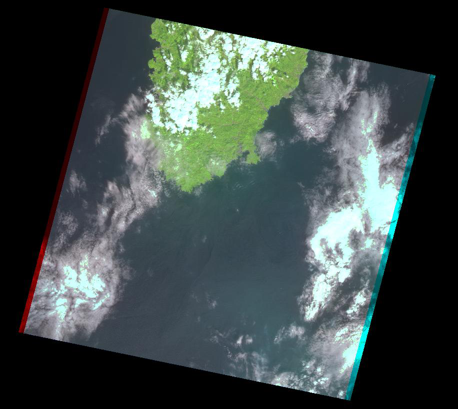

In [7]:
from PIL import Image
from urllib.request import urlopen

items = list(search.items())
item = items[len(items)//2]

asset_href = item.assets['vnir-browse'].href
signed_href = pc.sign(asset_href)

print(f"id={item.id}\tdate={item.datetime.date()}\tcloud %={item.ext.eo.cloud_cover}")

# Downsample a bit for plotting
image = Image.open(urlopen(signed_href))
image.resize(size=(image.width//2, image.height//2))

### Render an RGB composite from a complete scene
Of course, most of the time, you don't just want to browse thumbnails, you want to access images.  Let's render a composite image from the VNIR bands in one of the items.

In [8]:
import numpy as np

items = list(search.items())

# Let's pick the item with the least cloud cover
cloud_cover = [item.ext.eo.cloud_cover for item in items]
i_item = np.argmin(cloud_cover)

item = items[i_item]
swir_asset = item.assets['VNIR']

Let's see what properties are available within each asset, and also print the bands available in this image:

In [9]:
available_assets = list(swir_asset.to_dict().keys())
print(available_assets)

available_bands = [band['name'] for band in swir_asset.to_dict()['eo:bands']]
print(available_bands)

['href', 'type', 'title', 'eo:bands', 'proj:shape', 'proj:bbox', 'proj:transform', 'roles']
['VNIR_Band1', 'VNIR_Band2', 'VNIR_Band3N']


Finally, let's render our RGB composite.

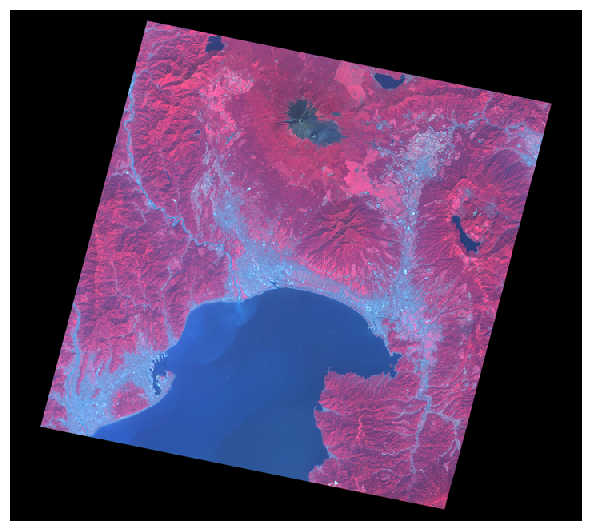

In [10]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Downsample the scene for plotting
dsfactor = 10

# Choose bands for our RGB composite
bands = [3,2,1]

# Normalization value for rendering
norm_value = 100

image_data = []

with rasterio.open(swir_asset.href,'r') as src:
    
    h = int(src.height//dsfactor)
    w = int(src.width//dsfactor)
    
    for i,band in enumerate(bands):
        band_array = src.read(band, out_shape=(1, h, w))
        band_array = band_array / norm_value
        image_data.append(band_array)
    src.close()
        
rgb = np.dstack((image_data[0],image_data[1],image_data[2]))
np.clip(rgb,0,1,rgb)

dpi=100; fig = plt.figure(frameon=False,figsize=(w/dpi,h/dpi),dpi=dpi)
ax = plt.Axes(fig,[0., 0., 1., 1.]); ax.set_axis_off(); fig.add_axes(ax)
plt.imshow(rgb);